In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

### Data Import

In [2]:
#Loading the datasets 
anime_data = pd.read_csv('C:\\Lessons\\Fa2022\\CS 512\\Project\\archive\\anime_with_synopsis.csv')
user_data = pd.read_csv('C:\\Lessons\\Fa2022\\CS 512\\Project\\archive\\rating_complete.csv', low_memory=False)
print(anime_data.shape)
anime_data.head()
print(user_data.shape)
user_data.head()

(16214, 5)
(57633278, 3)


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [3]:
# for anime, remove "Unkown" in score column
anime_data = anime_data[(anime_data["Score"] != "Unknown")]
print(anime_data.shape)
# remove anime withou sypnopsis
anime_data = anime_data[anime_data['sypnopsis'] != "No synopsis information has been added to this title. Help improve our database by adding a synopsis here ."]
print(anime_data.shape)

(11091, 5)
(10915, 5)


In [4]:
# rearrange anime_data via unique anime_id
anime_ids = anime_data['MAL_ID'].unique().tolist()
anime2_encoded = {x: i for i, x in enumerate(anime_ids)}
encoded2_anime = {i: x for i, x in enumerate(anime_ids)}
anime_data["anime"] = anime_data["MAL_ID"].map(anime2_encoded)

# user_data.head()
anime_data.head(10)

,MAL_ID,Name,Score,Genres,sypnopsis,anime
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",1
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",2
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,3
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,4
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...,5
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college...",6
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...,7
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...,8
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent...",9


In [5]:
# rearrange user_data via unique anime_id
# anime_data_to_merge = anime_data[['MAL_ID','anime']]
user_data = user_data.merge(anime_data,left_on="anime_id",right_on="MAL_ID",how='left')
user_data=user_data[['user_id','anime_id','rating','anime']]
user_data.head()

,user_id,anime_id,rating,anime
0,0,430,9,392.0
1,0,1004,5,885.0
2,0,3010,7,2471.0
3,0,570,7,524.0
4,0,2762,9,2317.0


### Content-based Recommendation
- Note: all anime-indexs below are rearranged index, i.e. anime_data['anime'].

In [6]:
def get_anime_ids(user_id):
    return user_data[user_data['user_id']==user_id]['anime'].values.tolist()

def get_anime_ratings(anime_index):
    rating = anime_data['Score'].iloc[anime_index]
    return float(rating)

# return corresponding recommendation lists (overall rating>6) based on anime which the user watched and rated >= 7
def recommend(user_id, similarity_matrix, number_of_recommendations = 10):
    anime_ids_list = get_anime_ids(user_id)
    index_list = []
    for anime in anime_ids_list:
        rating = get_anime_ratings(int(anime))
        if rating >= 7:
            index_list.append(int(anime))
    recommend_dict = {}
    for index in index_list:
        recommend_list = []
        similarity_scores = sorted(list(enumerate(similarity_matrix[index])),key=lambda x: x[1], reverse=True)
        recommendations_indices = [t[0] for t in similarity_scores[1:(number_of_recommendations+1)]]
        for anime_index in recommendations_indices:
            rating = get_anime_ratings(anime_index)
            if rating > 6:
                recommend_list.append(anime_index)
            recommend_dict[index] = recommend_list
    return recommend_dict

# return top 10 recommedations after finding all possible recommendation lists
def get_top_10_recommedation(recommend_dict):
    full_list = []
    for item in recommend_dict:
        for index in recommend_dict[item]:
            rating = get_anime_ratings(index)
            if [index,rating] not in full_list:
                full_list.append([index,rating])
    full_list = sorted(full_list,key=lambda x: x[1])
    top_10_list = [elem[0] for elem in full_list[len(full_list)-10:]]
    return anime_data['Name'].iloc[top_10_list]

1. Content-based recommendation only based on the anime's sypnopsis

[[1.         0.22971839 0.01532281 ... 0.03230443 0.         0.        ]
 [0.22971839 1.         0.03620435 ... 0.         0.         0.        ]
 [0.01532281 0.03620435 1.         ... 0.         0.         0.        ]
 ...
 [0.03230443 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.24083507]
 [0.         0.         0.         ... 0.         0.24083507 1.        ]]


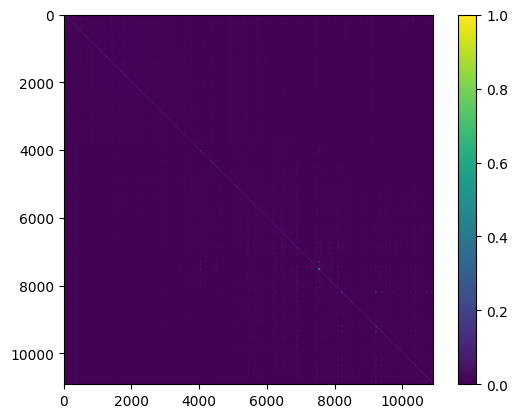

In [7]:
# represent sypnopsis via TF-IDF values to calculate their similarity
tf_idf = TfidfVectorizer(stop_words='english')
tf_idf_matrix = tf_idf.fit_transform(anime_data['sypnopsis'].astype('U').values)

# calculating cosine similarity
cosine_similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
print(cosine_similarity_matrix)
plt.imshow(cosine_similarity_matrix)
plt.colorbar()

In [8]:
recommendation_list_1 = recommend(0,cosine_similarity_matrix)
print(recommendation_list_1)
print(get_top_10_recommedation(recommendation_list_1))

{392: [100, 3357, 4618, 9577, 6437, 7383, 2308, 5140, 1760, 2782], 885: [5958, 8113, 3657, 2735, 549, 9401, 9585, 8488], 2471: [3074, 4969, 2241, 3698, 5529, 1943, 8039, 2960], 524: [257, 28, 779, 638, 710, 874, 1084, 971, 3367], 2317: [2047, 6624, 5214, 3288, 1067, 489, 6749], 393: [9706, 9211, 10533, 3122, 1912, 3684, 135, 1664, 2444], 531: [6039, 1578, 234, 481, 1170, 3624, 7795], 395: [633, 8796, 2705, 6970, 10224, 10462, 2592], 1368: [1561, 8687, 615, 285, 1440, 10622, 267, 4984], 100: [3357, 392, 4618, 5140, 3797, 4441, 9577, 10650, 6437], 322: [6945, 6585, 8640, 7183, 8314, 4891, 8814, 5285, 9512, 7065], 1114: [8481, 7889, 7631, 7198, 4553, 5714, 10576, 420, 11], 2410: [1906, 2152, 4380, 3158, 4386, 10811, 3726, 3674, 4664], 1468: [432, 7218, 7368, 147, 3236, 6052, 5745, 9708, 5311], 49: [2183, 5410, 128, 6352], 2676: [3501, 1312, 5879, 2594, 2152, 2161, 806], 142: [8805, 584, 7622, 2019, 7174, 217], 377: [3858, 4252, 2467, 7599, 2280, 9332, 3270, 5029], 1939: [3402, 95, 6148, 6

2. Content-based recommendation based on hybrid feature (genre + sypnopsis)

In [9]:
# construct the hybrid feature
# the weight of genre is larger than that of sypnosis
w_genre = 5
w_sypnopsis = 1

def hybrid_feature(df_row):
    genres = df_row['Genres']
    sypnopsis=df_row['sypnopsis']
    
    return " ".join(map(str,([genres]*w_genre)))+' '+" ".join(map(str,([sypnopsis]*w_sypnopsis)))

anime_data['hybrid_feature'] = anime_data.apply(hybrid_feature,axis=1)

anime_data.head()

,MAL_ID,Name,Score,Genres,sypnopsis,anime,hybrid_feature
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",0,"Action, Adventure, Comedy, Drama, Sci-Fi, Spac..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",1,"Action, Drama, Mystery, Sci-Fi, Space Action, ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",2,"Action, Sci-Fi, Adventure, Comedy, Drama, Shou..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,3,"Action, Mystery, Police, Supernatural, Drama, ..."
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,4,"Adventure, Fantasy, Shounen, Supernatural Adve..."


[[1.         0.57621098 0.54220191 ... 0.04252433 0.         0.23181406]
 [0.57621098 1.         0.42018936 ... 0.         0.13877757 0.        ]
 [0.54220191 0.42018936 1.         ... 0.         0.12818322 0.20305751]
 ...
 [0.04252433 0.         0.         ... 1.         0.         0.        ]
 [0.         0.13877757 0.12818322 ... 0.         1.         0.02382134]
 [0.23181406 0.         0.20305751 ... 0.         0.02382134 1.        ]]


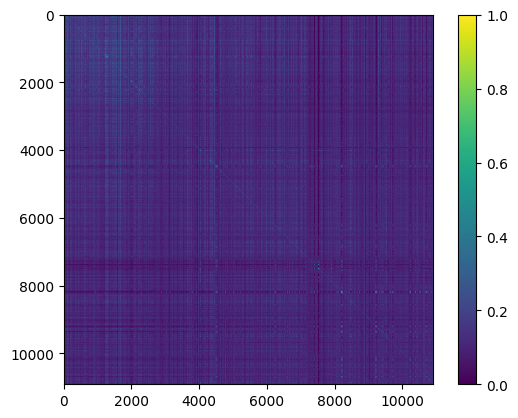

In [10]:
# convert hybrid features into comparable values
vect = CountVectorizer(stop_words='english')
vect_matrix = vect.fit_transform(anime_data['hybrid_feature'])

# calculating cosine similarity
cosine_similarity_matrix_count_based = cosine_similarity(vect_matrix, vect_matrix)
print(cosine_similarity_matrix_count_based)
plt.imshow(cosine_similarity_matrix_count_based)
plt.colorbar()

In [11]:
recommendation_list_2 = recommend(0,cosine_similarity_matrix_count_based)
print(recommendation_list_2)
print(get_top_10_recommedation(recommendation_list_2))

{392: [607, 8773, 100, 3357, 8338, 4618, 10074, 4728, 10311], 885: [5958, 585, 126, 10770, 10611, 613, 10835, 10160, 3501], 2471: [4364, 8388, 2887, 141, 3628, 1753, 882, 6340], 524: [1913, 4448, 9554, 694, 8377, 1298, 3446, 970], 2317: [2491, 8467, 473, 2964, 7140, 742, 8644, 646, 4884], 393: [10235, 9277, 1011, 5994, 103, 1901, 2869, 843, 5625], 531: [3624, 4415, 4849, 5478, 2460, 6759, 4868, 4869], 395: [1944, 1708, 510, 62, 245, 3235, 10392, 574, 324], 1368: [6552, 5409, 6553, 5655, 4638, 4656, 5410, 7594], 100: [3357, 4618, 607, 3797, 6445, 8602, 392, 9163, 3179, 8411], 322: [8315, 5422, 4175, 10602, 3984, 6945, 9895, 6585, 7183, 7065], 1114: [712, 4325, 8498, 5915, 8004, 9480, 421, 420, 4509, 1410], 2410: [5011, 2002, 2152, 6163, 2165, 5493, 10712, 3726, 2998, 4312], 1468: [10611, 126, 613, 10770, 636, 3790, 9628, 846], 49: [2183, 2804, 5366, 784, 2489, 786, 5054, 2533, 1395], 2676: [2260, 10492, 5127, 4938, 3672, 7717, 10817, 3636], 142: [9556, 9555, 9921, 10091, 10777, 7023, 10